In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 8.5 MB/s eta 0:00:00


--

Environment Description

CartPole-v1 : https://gymnasium.farama.org/environments/classic_control/cart_pole/

Acrobot-v1 : https://gymnasium.farama.org/environments/classic_control/acrobot/

MountainCar-v0 : https://gymnasium.farama.org/environments/classic_control/mountain_car/

--

In [83]:
import os
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



---



## 1. DQN Implemetation

In [121]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc_out = nn.Linear(256, action_dim)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = self.relu(self.fc1(s))
        q = self.fc_out(s)

        return q

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        self.epsilon_decay_rate = 0.995    # decay rate

        self.q_net = QNetwork(state_size, action_size).to(device)
        self.q_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()

    def update_target_network(self):
        self.q_target.load_state_dict(self.q_net.state_dict())

    def get_action(self, state, use_epsilon_greedy=True):
        if use_epsilon_greedy and random.random() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state_tensor)
            action = q_values.argmax().item()

        return action

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_samples(self, n):
        samples = random.sample(self.memory, n)
        s_batch = torch.tensor([s[0] for s in samples]).float().to(self.device)
        a_batch = torch.tensor([[s[1]] for s in samples]).long().to(self.device)
        r_batch = torch.tensor([[s[2]] for s in samples]).float().to(self.device)
        s_next_batch = torch.tensor([s[3] for s in samples]).float().to(self.device)
        done_batch = torch.tensor([[s[4]] for s in samples]).float().to(self.device)
        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay_rate, self.epsilon_min)

    def train(self):
        if len(self.memory) < self.train_start:
            return
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        target_values = r_batch + self.discount_factor * self.q_target(s_next_batch).detach().max(1)[0].unsqueeze(1) * (1 - done_batch)
        current_values = self.q_net(s_batch).gather(1, a_batch)
        loss = self.loss_function(current_values, target_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [ ]:
env_name          = "Acrobot-v1"

In [ ]:

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:6, action_size:3, max_episode_steps:500, device:cuda 

Epoch:0, Episode_score:-500.0, Episode_steps:500, epsilon:0.995
Epoch:10, Episode_score:-500.0, Episode_steps:500, epsilon:0.946354579813443
Epoch:20, Episode_score:-500.0, Episode_steps:500, epsilon:0.9000874278732445
Epoch:30, Episode_score:-500.0, Episode_steps:500, epsilon:0.8560822709551227
Epoch:40, Episode_score:-500.0, Episode_steps:500, epsilon:0.8142285204175609
Epoch:50, Episode_score:-500.0, Episode_steps:500, epsilon:0.7744209942832988
Epoch:60, Episode_score:-500.0, Episode_steps:500, epsilon:0.736559652908221
Epoch:70, Episode_score:-500.0, Episode_steps:500, epsilon:0.7005493475733617
Epoch:80, Episode_score:-106.0, Episode_steps:107, epsilon:0.6662995813682115
Epoch:90, Episode_score:-92.0, Episode_steps:93, epsilon:0.6337242817644086
Epoch:100, Episode_score:-89.0, Episode_steps:90, epsilon:0.6027415843082742
Epoch:110, Episode_score:-76.0, Episode_steps:77, epsilon:0.5732736268885887
Epoch:120, Episode

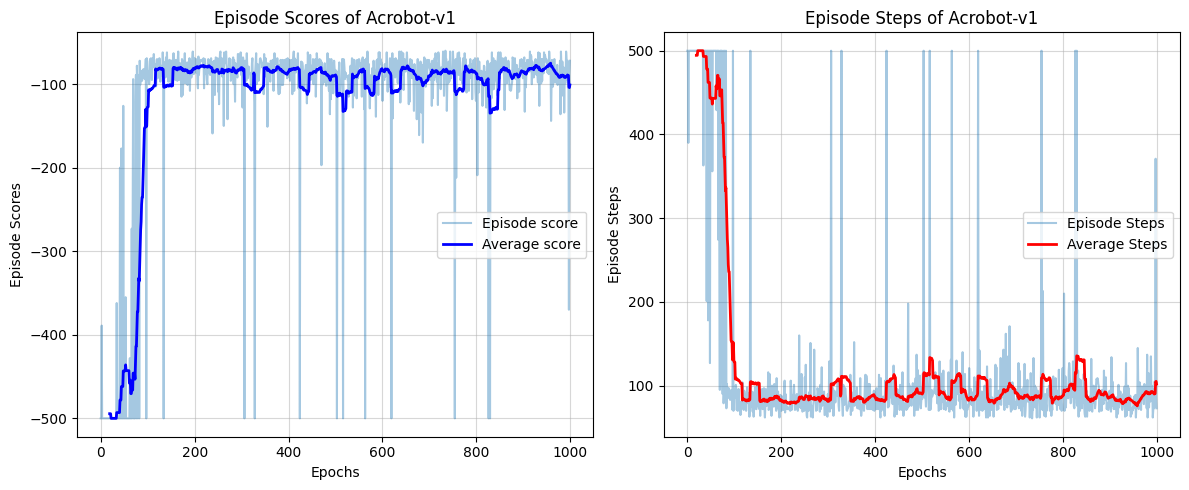

In [ ]:
import pandas as pd

window_size = 20

scores_ma = pd.Series(episode_scores_list).rolling(window=window_size).mean()
steps_ma = pd.Series(episode_steps_list).rolling(window=window_size).mean()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_scores_list, alpha=0.4, label='Episode score') 
plt.plot(scores_ma, color='blue', linewidth=2, label=f'Average score')
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title(f"Episode Scores of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(episode_steps_list, alpha=0.4, label='Episode Steps')
plt.plot(steps_ma, color='red', linewidth=2, label=f'Average Steps') 
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title(f"Episode Steps of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()



---



## 2. Double DQN implemantation

In [133]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc_out = nn.Linear(256, action_dim)
        self.relu = nn.ReLU()

    def forward(self, s):
        s = self.relu(self.fc1(s))
        q = self.fc_out(s)

        return q

In [ ]:
class DoubleDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size         = state_size
        self.action_size        = action_size
        self.device             = device

        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        self.epsilon_decay_rate = 0.995    # decay rate

        self.q_net = QNetwork(state_size, action_size).to(device)
        self.q_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        self.loss_function = nn.MSELoss()

    def update_target_network(self):
        self.q_target.load_state_dict(self.q_net.state_dict())

    def get_action(self, state, use_epsilon_greedy=True):
        if use_epsilon_greedy and random.random() < self.epsilon:
            action = random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_net(state_tensor)
            action = q_values.argmax().item()

        return action

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_samples(self, n):
        samples = random.sample(self.memory, n)
        s_batch = torch.tensor([s[0] for s in samples]).float().to(self.device)
        a_batch = torch.tensor([[s[1]] for s in samples]).long().to(self.device)
        r_batch = torch.tensor([[s[2]] for s in samples]).float().to(self.device)
        s_next_batch = torch.tensor([s[3] for s in samples]).float().to(self.device)
        done_batch = torch.tensor([[s[4]] for s in samples]).float().to(self.device)
        # i.e.) s_batch : (batch_size, state_dim)
        return s_batch, a_batch, r_batch, s_next_batch, done_batch

    def epsilon_decay(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay_rate, self.epsilon_min)

    def train(self):
        if len(self.memory) < self.train_start:
            return
        s_batch, a_batch, r_batch, s_next_batch, done_batch = self.get_samples(self.batch_size)

        best_actions = self.q_net(s_next_batch).argmax(dim=1).unsqueeze(1)
        next_q_values = self.q_target(s_next_batch).gather(1, best_actions).detach()
        target_values = r_batch + self.discount_factor * next_q_values * (1 - done_batch)

        current_values = self.q_net(s_batch).gather(1, a_batch)
        loss = self.loss_function(current_values, target_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
def evaluation(env, agent):
    done, episode_score, episode_steps = False, 0.0, 0

    state, _ = env.reset()
    for t in range(env._max_episode_steps):
        action = agent.get_action(state, use_epsilon_greedy=False)
        state_next, reward, done, time_truncation, _ = env.step(action)

        episode_score += reward
        episode_steps += 1

        state = state_next
        if done:
            break

    return episode_score, episode_steps


In [ ]:
env_name          = "Acrobot-v1"

In [ ]:

env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:6, action_size:3, max_episode_steps:500, device:cuda 

Epoch:0, Episode_score:-500.0, Episode_steps:500, epsilon:0.995
Epoch:10, Episode_score:-500.0, Episode_steps:500, epsilon:0.946354579813443
Epoch:20, Episode_score:-500.0, Episode_steps:500, epsilon:0.9000874278732445
Epoch:30, Episode_score:-500.0, Episode_steps:500, epsilon:0.8560822709551227
Epoch:40, Episode_score:-500.0, Episode_steps:500, epsilon:0.8142285204175609
Epoch:50, Episode_score:-500.0, Episode_steps:500, epsilon:0.7744209942832988
Epoch:60, Episode_score:-500.0, Episode_steps:500, epsilon:0.736559652908221
Epoch:70, Episode_score:-91.0, Episode_steps:92, epsilon:0.7005493475733617
Epoch:80, Episode_score:-162.0, Episode_steps:163, epsilon:0.6662995813682115
Epoch:90, Episode_score:-121.0, Episode_steps:122, epsilon:0.6337242817644086
Epoch:100, Episode_score:-103.0, Episode_steps:104, epsilon:0.6027415843082742
Epoch:110, Episode_score:-61.0, Episode_steps:62, epsilon:0.5732736268885887
Epoch:120, Episo

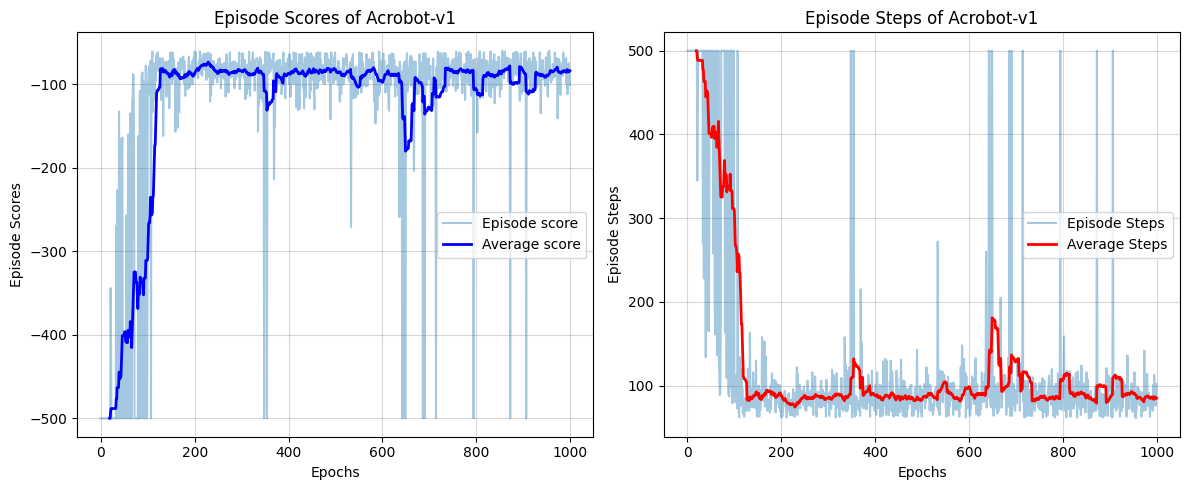

In [ ]:
window_size = 20

scores_ma = pd.Series(episode_scores_list).rolling(window=window_size).mean()
steps_ma = pd.Series(episode_steps_list).rolling(window=window_size).mean()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_scores_list, alpha=0.4, label='Episode score') 
plt.plot(scores_ma, color='blue', linewidth=2, label=f'Average score')
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title(f"Episode Scores of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(episode_steps_list, alpha=0.4, label='Episode Steps')
plt.plot(steps_ma, color='red', linewidth=2, label=f'Average Steps') 
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title(f"Episode Steps of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()



---



## 3. Additional Implementation

In [ ]:
# Dueling Double Deep Q learning

class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingQNetwork, self).__init__()
        
        self.feature_layer = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, state):
        features = self.feature_layer(state)
        v = self.value_stream(features)
        a = self.advantage_stream(features)
        q_values = v + (a - a.mean(dim=-1, keepdim=True))
        
        return q_values
    
class DuelingDoubleDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        self.Epochs             = 1000
        self.discount_factor    = 0.98
        self.learning_rate      = 0.001  # learning rate for q function
        self.epsilon            = 1.0    # initial epsilon value
        self.epsilon_min        = 0.001  # minimum epsilon value
        self.batch_size         = 256
        self.train_start        = self.batch_size * 5
        self.memory             = deque(maxlen=100000)  # replay memory

        self.epsilon_decay_rate = 0.995    # decay rate
        
        self.q_net = DuelingQNetwork(state_size, action_size).to(device)
        self.q_target = DuelingQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.learning_rate)
        
        self.update_target_network()

    def update_target_network(self):
        self.q_target.load_state_dict(self.q_net.state_dict())

    def get_action(self, state, use_epsilon_greedy=True):
        if use_epsilon_greedy and random.random() < self.epsilon:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.q_net(state_tensor)
                return q_values.argmax().item()

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def epsilon_decay(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay_rate, self.epsilon_min)

    def train(self):
        if len(self.memory) < self.train_start:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        
        with torch.no_grad():
            best_actions = self.q_net(next_states).argmax(dim=1).unsqueeze(1)
            next_q_values = self.q_target(next_states).gather(1, best_actions)
            target_q_values = rewards + (1 - dones) * self.discount_factor * next_q_values

        current_q_values = self.q_net(states).gather(1, actions)
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
env_name          = "Acrobot-v1"

In [ ]:
env               = gym.make(env_name)
state_size        = env.observation_space.shape[0]
action_size       = env.action_space.n
max_episode_steps = env._max_episode_steps
device            = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("state_size:{}, action_size:{}, max_episode_steps:{}, device:{} \n".format(state_size, action_size, max_episode_steps, device))

agent = DuelingDoubleDQNAgent(state_size, action_size, device)



episode_scores_list, episode_steps_list = [], []
for epoch in range(agent.Epochs):  # agent.Epochs = 1000

    state, _ = env.reset()
    for t in range(max_episode_steps):
        action = agent.get_action(state)
        state_next, reward, done, time_truncation, _ = env.step(action)

        agent.append_sample(state, action, reward, state_next, done)

        if len(agent.memory) >= agent.train_start:
            agent.train()

        state = state_next
        if done:
            state, _ = env.reset()

    agent.update_target_network()
    agent.epsilon_decay()

    episode_score, episode_steps = evaluation(env, agent)
    episode_scores_list.append(episode_score)
    episode_steps_list.append(episode_steps)

    if epoch % 10 == 0:
        print("Epoch:{}, Episode_score:{}, Episode_steps:{}, epsilon:{}".format(epoch, episode_score, episode_steps, agent.epsilon))



state_size:6, action_size:3, max_episode_steps:500, device:cuda 

Epoch:0, Episode_score:-500.0, Episode_steps:500, epsilon:0.995
Epoch:10, Episode_score:-500.0, Episode_steps:500, epsilon:0.946354579813443
Epoch:20, Episode_score:-500.0, Episode_steps:500, epsilon:0.9000874278732445
Epoch:30, Episode_score:-500.0, Episode_steps:500, epsilon:0.8560822709551227
Epoch:40, Episode_score:-500.0, Episode_steps:500, epsilon:0.8142285204175609
Epoch:50, Episode_score:-500.0, Episode_steps:500, epsilon:0.7744209942832988
Epoch:60, Episode_score:-500.0, Episode_steps:500, epsilon:0.736559652908221
Epoch:70, Episode_score:-500.0, Episode_steps:500, epsilon:0.7005493475733617
Epoch:80, Episode_score:-500.0, Episode_steps:500, epsilon:0.6662995813682115
Epoch:90, Episode_score:-500.0, Episode_steps:500, epsilon:0.6337242817644086
Epoch:100, Episode_score:-500.0, Episode_steps:500, epsilon:0.6027415843082742
Epoch:110, Episode_score:-283.0, Episode_steps:284, epsilon:0.5732736268885887
Epoch:120, E

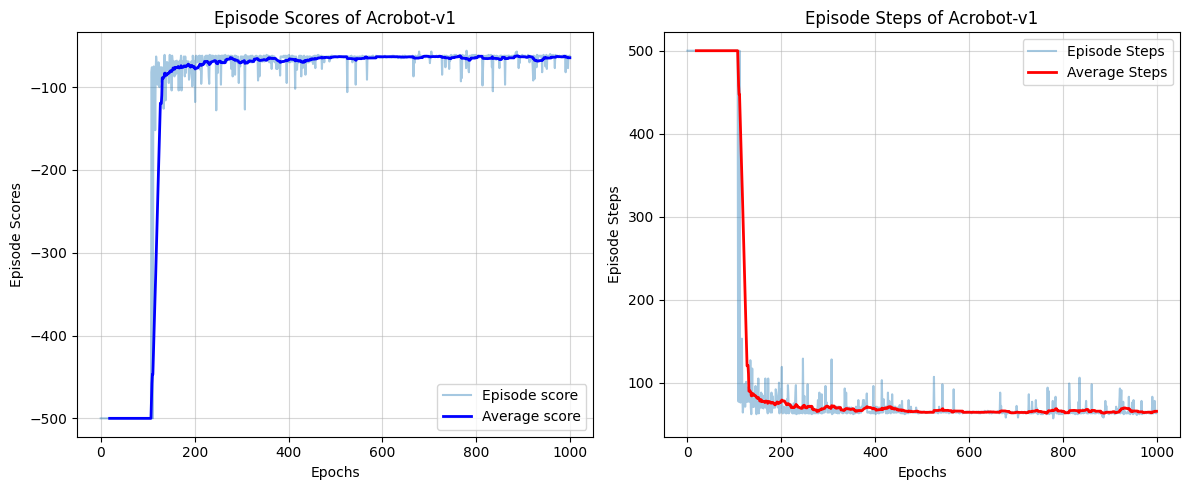

In [ ]:
window_size = 20

scores_ma = pd.Series(episode_scores_list).rolling(window=window_size).mean()
steps_ma = pd.Series(episode_steps_list).rolling(window=window_size).mean()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_scores_list, alpha=0.4, label='Episode score') 
plt.plot(scores_ma, color='blue', linewidth=2, label=f'Average score')
plt.xlabel("Epochs")
plt.ylabel("Episode Scores")
plt.title(f"Episode Scores of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(episode_steps_list, alpha=0.4, label='Episode Steps')
plt.plot(steps_ma, color='red', linewidth=2, label=f'Average Steps') 
plt.xlabel("Epochs")
plt.ylabel("Episode Steps")
plt.title(f"Episode Steps of {env_name}")
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()